# Compute forcing data from OpenIFS runs

The log file "NODE.001_01" from OpenIFS writes all forcing data in text format every day. 
We here read from this file to get solar constant and all greenhouse-gas concentrations. 

* FOCI_GJK029 - piControl
* FOCI_GJK030 - historical 
* FOCI_GJK031 - 4xCO2
* FOCI_GJK032 - 1pctCO2

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import cftime
import pandas as pd
import os

In [10]:
## Find NODE file
exp = 'FOCI_GJK029'
#exp = 'FOCI_GJK029'
step = 10
node_files = []
for year in range(1850,3000,step):
    timestamp = '%04d0101-%04d1231' % (year,year+step-1)
    file = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/log/oifs/NODE.001_01_%s' % (exp,timestamp)
    if os.path.isfile(file):
        node_files.append(file)

In [11]:
node_files

['/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18500101-18591231',
 '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18600101-18691231',
 '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18700101-18791231',
 '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18800101-18891231',
 '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18900101-18991231',
 '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_19000101-19091231',
 '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_19100101-19191231',
 '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_19200101-19291231',
 '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_19300101-19391231',
 '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_19400101-19491231',
 '/gxfs_wo

In [12]:
def read_forcing_from_node(file):
    f = open(file,'r')
    lines = f.readlines()
    
    dates = []
    co2   = []
    ch4   = []
    n2o   = []
    cfc11 = []
    cfc12 = []
    no2   = []
    sol   = []
    
    date_cf_prev = None
    
    for i,line in enumerate(lines):
        
        # JGAS= 1 is CO2
        if 'JGAS=           1' in line:
            
            # split line
            # JGAS=1 is CO2
            # then comes CH4, N2O, CFC11, CFC12, NO2
            co2_data = line.split(' ')
            ch4_data = lines[i+1].split(' ')
            n2o_data = lines[i+2].split(' ')
            cfc11_data = lines[i+3].split(' ')
            cfc12_data = lines[i+4].split(' ')
            no2_data = lines[i+5].split(' ')
            
            # solar forcing
            sol_data = lines[i+7].split(' ')
            
            # remove empty strings (just spaces)
            co2_data = list(filter(None, co2_data))
            ch4_data = list(filter(None, ch4_data))
            n2o_data = list(filter(None, n2o_data))
            cfc11_data = list(filter(None, cfc11_data))
            cfc12_data = list(filter(None, cfc12_data))
            no2_data = list(filter(None, no2_data))
            sol_data = list(filter(None, sol_data))
            
            # the date is 12 lines down (usually...)
            date_line = lines[i+12]
            
            # if this is DATE
            if 'DATE' in date_line:
                
                # split 
                data = date_line.split(' ')
                # remove spaces
                data = list(filter(None, data))
                
                # strip away newline, convert to ints and 
                # make a string YYYY-MM-DD
                y = int(data[1])
                m = int(data[2])
                d = int(data[3].strip())
                
                #dates.append('%04d-%02d-%02d' % (int(data[1]),int(data[2]),int(data[3].strip())))
                date_cf = cftime.datetime(y,m,d, 
                                          hour=0, calendar=u'standard')
                
                # only add data if its not the same day as before
                if date_cf_prev != None:
                    #print(date_cf, date_cf_prev)
                    if date_cf != date_cf_prev:
                        dates.append(date_cf)
                        
                        # and take the co2 data
                        co2.append(float(co2_data[3]))
                        # and other gases
                        ch4.append(float(ch4_data[3]))
                        n2o.append(float(n2o_data[3]))
                        cfc11.append(float(cfc11_data[3]))
                        cfc12.append(float(cfc12_data[3]))
                        no2.append(float(no2_data[3]))
                        # and solar
                        sol.append(float(sol_data[1]))
                
                date_cf_prev = date_cf
        
        #if i > 10000:
        #    break 
    
    f.close()
    
    # convert string of dates to datetime objects
    # pandas does this best
    # commented out: We cant use pandas since it wont allow us 
    # to go beyond year 2262. 
    #dates_pd = pd.to_datetime(dates)
    
    # year of start
    y = dates[0].year
    # make a cftime range for this year
    # assuming daily data
    cf_dates = xr.cftime_range(start='%d' % (y,), periods=len(co2), freq='D')
    
    # make DataArrays
    varnames = ['co2','ch4','n2o','cfc11','cfc12','no2','sol']
    dlists = [co2, ch4, n2o, cfc11, cfc12, no2, sol]
    dalist = []
    for (varname, dlist) in zip(varnames, dlists):
        da = xr.DataArray( 
            data=dlist,
            dims=["time"],
            coords=dict(
                time=cf_dates),
            attrs=dict(
                description="%s" % (varname,),
                units="ppm"),
        )
        da.name = "%s" % (varname,)
        dalist.append(da)
    
    ds = xr.merge(dalist)
    
    return ds

In [13]:
ds_list = []

for i, node_file in enumerate(node_files):
    
    print(' Read data from %s ' % (node_file,))
    ds = read_forcing_from_node(node_file)
    
    ds_list.append(ds)

 Read data from /gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18500101-18591231 
 Read data from /gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18600101-18691231 
 Read data from /gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18700101-18791231 
 Read data from /gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18800101-18891231 
 Read data from /gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_18900101-18991231 
 Read data from /gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_19000101-19091231 
 Read data from /gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_19100101-19191231 
 Read data from /gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_19200101-19291231 
 Read data from /gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK029/log/oifs/NODE.001_01_19300101-19

In [14]:
ds_all = xr.concat(ds_list, dim='time')
ds_all

<xarray.Dataset>
Dimensions:  (time: 420029)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2999-12-31 00:00:00
Data variables:
    co2      (time) float64 284.3 284.3 284.3 284.3 ... 284.3 284.3 284.3 284.3
    ch4      (time) float64 808.2 808.2 808.2 808.2 ... 808.2 808.2 808.2 808.2
    n2o      (time) float64 273.0 273.0 273.0 273.0 ... 273.0 273.0 273.0 273.0
    cfc11    (time) float64 32.11 32.11 32.11 32.11 ... 32.11 32.11 32.11 32.11
    cfc12    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    no2      (time) float64 500.0 500.0 500.0 500.0 ... 500.0 500.0 500.0 500.0
    sol      (time) float64 1.361e+03 1.361e+03 ... 1.361e+03 1.361e+03
Attributes:
    description:  co2
    units:        ppm

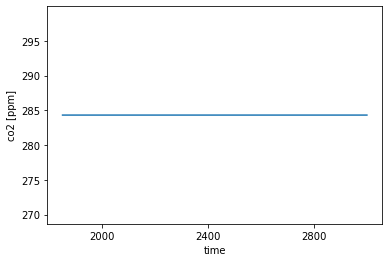

In [15]:
ds_all['co2'].plot()

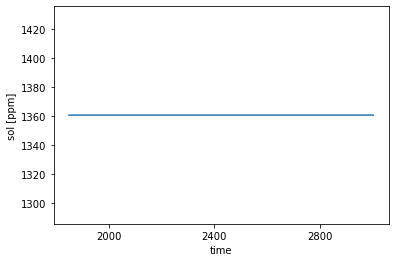

In [17]:
ds_all['sol'].plot()

In [16]:
# Remove old file
file = 'data/%s_forcing.nc' % (exp,)
if os.path.isfile(file):
    os.system('rm -f %s' % (file,))

# Make a dataset and write to netCDF
ds_all.to_netcdf(file)